In [2]:
import tensorflow as tf

import cProfile

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
x = [[2.]]
m = tf.matmul(x, x)
print(m)

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


In [4]:
a = tf.constant([[1,2], [3,4]])

In [5]:
b = tf.add(a, 1)
print(a, b)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32) tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [6]:
import numpy as np

c = np.multiply(a,b)

In [7]:
print(c)

[[ 2  6]
 [12 20]]


In [8]:
d = np.dot(a, b)

In [9]:
print(d)

[[10 13]
 [22 29]]


In [10]:
e = tf.constant(d)

In [11]:
print(e)

tf.Tensor(
[[10 13]
 [22 29]], shape=(2, 2), dtype=int32)


In [12]:
f = tf.Variable(d)
print(f)

<tf.Variable 'Variable:0' shape=(2, 2) dtype=int32, numpy=
array([[10, 13],
       [22, 29]], dtype=int32)>


In [13]:
print(tf.convert_to_tensor([5, 6]).numpy()+1)
print(tf.constant(5).numpy())

[6 7]
5


In [14]:
w = tf.ones((1,1))
print(w)
with tf.GradientTape() as tape:
    tape.watch(w)
    loss = w * w

grad = tape.gradient(loss, w)
print(grad)


tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [15]:
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [16]:
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])


In [17]:
print(dataset)
for images,labels in dataset.take(1):
    print(images)
    print(labels)
    print("로짓: ", mnist_model(images[0:1]).numpy())


<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int64)>
tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
  

In [67]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_history = [] #array...

def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training=True)
        tf.debugging.assert_equal(logits.shape, (32, 10))
        loss_value = loss_object(labels, logits)
    
    print('logits = {}, loss_value = {}'.format(logits.shape, loss_value))
    #print(loss_value.numpy())
    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    print('grads = {} : {}'.format(type(grads), len(grads)))
    print('trainable_variables = {}'.format(len(mnist_model.trainable_variables)))
    for idx, tv in enumerate(mnist_model.trainable_variables):
        print('trainable_variables[{}] = {}, {}'.format(idx, tv.name, tv.shape))
    #print(zip(grads, mnist_model.trainable_variables))
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [68]:
def train():
  for epoch in range(3):
    for (batch, (images, labels)) in enumerate(dataset):
        print('batch = {}, images = {}, labels = {}'.format(batch, images.shape, labels.shape))
        train_step(images, labels)
        if batch == 5:
          break
    print ('에포크 {} 종료'.format(epoch))


In [69]:
# mnist_model = tf.keras.Sequential([
#   tf.keras.layers.Conv2D(16,[3,3], activation='relu',
#                          input_shape=(None, None, 1)),
#   tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
#   tf.keras.layers.GlobalAveragePooling2D(),
#   tf.keras.layers.Dense(10)
# ])
train()


batch = 0, images = (32, 28, 28, 1), labels = (32,)
logits = (32, 10), loss_value = 2.242607593536377
grads = <class 'list'> : 6
trainable_variables = 6
trainable_variables[0] = conv2d/kernel:0, (3, 3, 1, 16)
trainable_variables[1] = conv2d/bias:0, (16,)
trainable_variables[2] = conv2d_1/kernel:0, (3, 3, 16, 16)
trainable_variables[3] = conv2d_1/bias:0, (16,)
trainable_variables[4] = dense/kernel:0, (16, 10)
trainable_variables[5] = dense/bias:0, (10,)
batch = 1, images = (32, 28, 28, 1), labels = (32,)
logits = (32, 10), loss_value = 2.2926642894744873
grads = <class 'list'> : 6
trainable_variables = 6
trainable_variables[0] = conv2d/kernel:0, (3, 3, 1, 16)
trainable_variables[1] = conv2d/bias:0, (16,)
trainable_variables[2] = conv2d_1/kernel:0, (3, 3, 16, 16)
trainable_variables[3] = conv2d_1/bias:0, (16,)
trainable_variables[4] = dense/kernel:0, (16, 10)
trainable_variables[5] = dense/bias:0, (10,)
batch = 2, images = (32, 28, 28, 1), labels = (32,)
logits = (32, 10), loss_value = 2

Text(0, 0.5, 'Loss [entropy]')

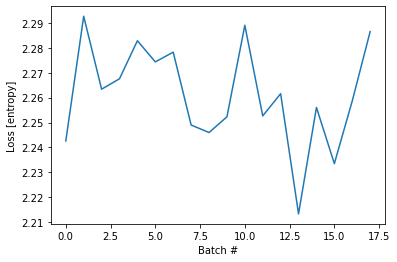

In [70]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')


In [105]:
l = tf.Variable([[2, 4], [6, 8]])
print(tf.square(l-1))
c = tf.reduce_mean(tf.square(l-1))
print(c)

# for x, y in enumerate(l):
#     print(x, y)
#     for z in y:
#         print(z)
print(np.mean(l.numpy()))
# for y in l.numpy():
#     print(y)
#     for z in y:
#         print(z)


tf.Tensor(
[[ 1  9]
 [25 49]], shape=(2, 2), dtype=int32)
tf.Tensor(21, shape=(), dtype=int32)
5.0


In [113]:
x1 = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x1)
x1.assign(2.)   # 변수에 새로운 값을 할당하고 저장
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [120]:
x1.assign(11.)  # 저장한 후에 변수 변경
print(x1)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=11.0>


In [121]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x1)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


In [124]:
if tf.config.experimental.list_physical_devices("GPU"):
    x = tf.random.normal([10, 10])
    print(x)
    x_gpu0 = x.gpu()
    print(x_gpu0)
    x_cpu = x.cpu()

    _ = tf.matmul(x_cpu, x_cpu)    # CPU에서 실행
    _ = tf.matmul(x_gpu0, x_gpu0)  # GPU:0에서 실행

tf.Tensor(
[[-0.89652     0.1645122   0.5719512  -0.93718475  0.3064624   0.11849971
  -0.8864141  -1.4383634   0.740714    0.7929607 ]
 [-0.5967527   0.6190684   0.41986784 -0.13430747 -1.1391798   0.83187574
   0.576894   -0.01099483  0.4475941   0.9526349 ]
 [-0.7713416   0.11173362 -0.97250795  0.61493725 -0.95605636 -1.5554916
  -0.12744378 -0.7357163   2.162834   -0.9306199 ]
 [-0.46036685  0.9395578   1.0905731  -1.0605161   0.21641746  0.7645008
  -1.3515042   2.8675554  -1.0997726  -0.7230181 ]
 [-1.026391   -0.8283129   1.5668818  -1.5580293  -0.24538861  0.9566878
   0.43846554 -0.49396303 -0.583527    0.80831736]
 [ 1.2335721  -0.3019705   0.9180596   0.02800184  1.1656786  -1.0034095
  -0.83139116  0.36175945 -0.12606218 -0.16602524]
 [-0.98480725  0.72413963 -0.4722459  -1.3140428   0.45458388 -0.3891311
  -2.2528064   1.6429925  -0.49386975  0.35262385]
 [ 0.7160888  -0.5484946   0.7601001   0.49504316 -0.8192527   1.2878631
   1.4333923  -1.0980748  -0.18367177  1.34201

In [128]:
import time

def measure(x, steps):
  # 텐서플로는 처음 사용할 때 GPU를 초기화, 시간계산에서 제외
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  # tf.matmul는 행렬 곱셈을 완료하기 전에 결과를 반환할 수 있습니다
  # (예, CUDA 스트림 대기열에 연산을 추가한 후에 결과를 반환할 수 있다).
  # 아래 x.numpy() 호출은 대기열에 추가된 모든 연산이 완료될 것임을 보장합니다
  # (그리고 그 결과가 호스트 메모리에 복사될 것이고,
  # 그래서 matnul 연산시간보다는 조금 많은 연산시간이
  # 포함됩니다).
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("{} 크기 행렬을 자기 자신과 {}번 곱했을 때 걸리는 시간:".format(shape, steps))

# CPU에서 실행:
with tf.device("/cpu:0"):
  print("CPU: {} 초".format(measure(tf.random.normal(shape), steps)))

# GPU에서 실행, 가능하다면:
if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    xx = tf.random.normal(shape)
    xx_gpu0 = xx.gpu()
    xx_cpu = xx.cpu()
    print("GPU: {} 초".format(measure(xx_gpu0, steps)))
    print("CPU: {} 초".format(measure(xx_cpu, steps)))
else:
  print("GPU: 없음")

(1000, 1000) 크기 행렬을 자기 자신과 200번 곱했을 때 걸리는 시간:
CPU: 1.6137607097625732 초
GPU: 0.5444281101226807 초
CPU: 0.4530205726623535 초
